In [3]:
import numpy as np
#from sklearn import datasets

import torch
import torch.nn as nn
import torch.optim as optim

import torchbnn as bnn
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
torch.cuda.is_available()

True

In [4]:
import scipy.io
mat = scipy.io.loadmat('Car_Dataset_hyst_10s_N1000_v3.mat')
RV = mat['param'].T 
tin = mat['t']
# # mat['resp_all'].shape
xlow_all = mat['accel_LF'].T 
# mat = scipy.io.loadmat('DeepONet_degrading_data_v2.mat')
#xhigh_all = mat['accel_HF'].T
xhigh_all = mat['disp_HF'].T

In [5]:
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'accel_HF', 'accel_LF', 'disp_HF', 'disp_LF', 'p_mean', 'p_var', 'param', 't'])

In [6]:
mat['param'].T.shape

(1000, 5)

In [7]:
mat = scipy.io.loadmat('road_surface.mat')
w1 = mat['w1'] 

In [8]:
w1.shape

(1, 601)

In [9]:
data_min = w1.min()
data_max = w1.max()

normalized_w1 = (w1 - data_min) / (data_max - data_min) * 2 - 1

In [10]:
data_min = xhigh_all.min()
data_max = xhigh_all.max()

normalized_xhigh_all = (xhigh_all - data_min) / (data_max - data_min) * 2 - 1

In [11]:
xhigh_all.shape

(601, 1000)

In [12]:
tin.shape

(1, 601)

In [13]:
normalized_w1.shape

(1, 601)

In [14]:
normalized_w1[0,:].shape

(601,)

In [15]:
io=np.zeros((100,601,2))

In [16]:
io[0,:,0]=normalized_w1[0,:]

In [17]:
io[0,:,0].shape

(601,)

In [18]:
io.shape

(100, 601, 2)

In [18]:
nt = 601 
ni = 1000 # Number of parameter combinations 
nin = 7

np.random.seed(0)
io = np.zeros((ni,int(nt),nin))
op = np.zeros((ni,int(nt))) 
# xlow_all = np.zeros((ni,int(nt)))
# xhigh_all = np.zeros((ni,int(nt)))
tmax = 10 # For training 10s data used


for i in range(ni): 
    io[i,:,0] = (w1[0,:])
    io[i,:,1] = -1.0+2*(tin-np.amin(tin))/(tmax-np.amin(tin))
    
    for j in range(5): 
        io[i,:,2+j] = -1.0+2*(RV[i,j]*np.ones((nt,))-np.amin(RV[:,j]))/(np.amax(RV[:,j])-np.amin(RV[:,j])) 
   
#     op[i,:] = (-1.0+(xhigh_all[:,i]-xlow_all[:,i]))/2.0 # For BF training
    op[i,:] = (-1.0+(xhigh_all[:,i]))/2.0 # For HF training

In [19]:
io.shape

(1000, 601, 7)

In [510]:
RV.shape

(1000, 5)

### Without Stiffness

In [19]:
import os
from datetime import datetime
direct= os.path.join(os.getcwd(),'logs')
today_date = datetime.now().strftime('%Y-%m-%d')

In [20]:
nt = 601 
ni = 1000 # Number of parameter combinations 
nin = 2

np.random.seed(0)
io = np.zeros((ni,int(nt),nin))
op = np.zeros((ni,int(nt))) 
# xlow_all = np.zeros((ni,int(nt)))
# xhigh_all = np.zeros((ni,int(nt)))
tmax = 10 # For training 10s data used


for i in range(ni): 
    io[i,:,0] = normalized_w1[0,:]
    io[i,:,1] = -1.0+2*(tin-np.amin(tin))/(tmax-np.amin(tin))   
#     op[i,:] = (-1.0+(xhigh_all[:,i]-xlow_all[:,i]))/2.0 # For BF training
    op[i,:] = normalized_xhigh_all[:,i] # For HF training
    #op[i,:] = xhigh_all[:,i]
  

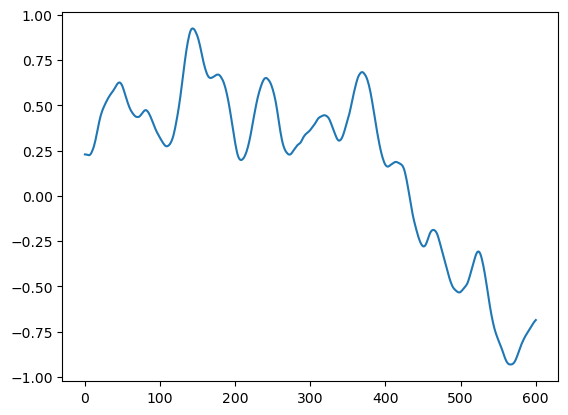

In [21]:
plt.plot(op[1,:])

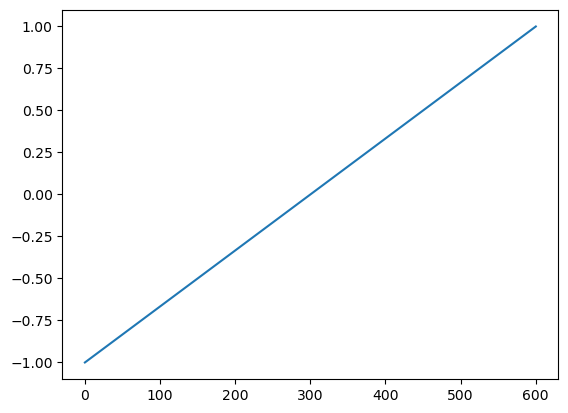

In [22]:
plt.plot(io[1,:,1])

In [23]:
io.shape

(1000, 601, 2)

In [24]:
op.shape

(1000, 601)

In [234]:
io_train=io[:50,:,:]
op_train=op[:50,:]

In [235]:
io_train.shape

(50, 601, 2)

In [236]:
op_train.shape

(50, 601)

In [237]:
x=io_train.reshape(-1,2)

In [238]:
y=op_train.reshape(-1,1)

In [239]:
x=torch.tensor(x, dtype=torch.float32)
y=torch.tensor(y, dtype=torch.float32)

In [241]:
shuffled_indicies=torch.randperm(x.shape[0])

In [242]:
shuffled_indicies

tensor([17159, 11873, 17300,  ...,   148, 18300, 23777])

In [243]:
torch.save(shuffled_indicies,'indiciies')

In [244]:
shuffled_indicies=torch.load('indiciies')

In [245]:
shuffled_indicies.shape

torch.Size([30050])

In [246]:
x_torch=x[shuffled_indicies]

In [247]:
y_torch=y[shuffled_indicies]

In [259]:
model_car = nn.Sequential(
    bnn.BayesLinear(prior_mu=0, prior_sigma=1, in_features=2, out_features=100),
    nn.BatchNorm1d(50),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=1, in_features=100, out_features=1),
    nn.BatchNorm1d(1)
)

In [388]:
import torch.nn as nn

# Define the deterministic neural network
model_car = nn.Sequential(
    nn.Linear(in_features=2, out_features=50),  # Replace BayesLinear with Linear
    nn.BatchNorm1d(50),
    nn.Tanh(),
    nn.Linear(in_features=50, out_features=1),  # Replace BayesLinear with Linear
    nn.BatchNorm1d(1)
)


In [389]:
bnn_parameters = {
        "prior_mu": 0.0,
        "prior_sigma": 1,
        "posterior_mu_init": 0.0,
        "posterior_rho_init": 0.0,
        "type": "Reparameterization",  # Flipout or Reparameterization
        "moped_enable": True,  # True to initialize mu/sigma from the pretrained dnn weights
        "moped_delta": 0.5,
}

In [390]:
from bayesian_torch.models.dnn_to_bnn import dnn_to_bnn, get_kl_loss

In [391]:
dnn_to_bnn(model_car, bnn_parameters)

In [392]:
ler=0.1
kl_weight=1.5
iterations=50
optimizer = torch.optim.Adam(model_car.parameters(), lr=ler)

In [393]:
mse_loss = nn.MSELoss()

kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)


In [394]:
def relative_mse(pre,target):
    nume=np.linalg.norm((target-pre), ord=2)
    deno=np.linalg.norm(target, ord=2)
    relativemse=nume/deno
    return relativemse

In [395]:
from torch.utils.data import DataLoader

In [396]:
dataset = torch.utils.data.TensorDataset(x_torch, y_torch)

In [397]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=15025, shuffle=True)

In [398]:
batch_x, batch_y = next(iter(dataloader))

In [399]:
batch_x.shape

torch.Size([15025, 2])

In [400]:
batch_y.shape

torch.Size([15025, 1])

In [401]:
batch_x.shape

torch.Size([15025, 2])

In [402]:
batch_x.shape

torch.Size([15025, 2])

In [403]:
batch_x.shape

torch.Size([15025, 2])

In [404]:
batch_x.view(-1,2).shape

torch.Size([15025, 2])

In [405]:
#rel_mse_list=[]
mse_list=[]
kl_losses=[]

for epoch in range(iterations): 
    for entries in range(2):
        batch_x,batch_y=next(iter(dataloader))          
        pre = model_car(batch_x)
        
        #print(pre)
        #nump_pre=pre.cpu().detach().numpy()
        #print(nump_pre) .
        #nump_target=(y_torch[entry,:,:].T).cpu().detach().numpy()
        #rel_mse=relative_mse(nump_pre,nump_target)
            
        mse = mse_loss(pre,batch_y)
        #rel_mse_list_epochs.append(rel_mse)
            
        #mse_list.append(mse.cpu().detach().numpy())
        mse_list.append(mse.detach().numpy())
        kl = get_kl_loss(model_car)
        kl_losses.append(kl.item())
        cost = mse + kl_weight*(kl/(batch_x.shape[0]))
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

print('- MSE : %2.5f, KL : %2.5f' % (mse.item(), kl.item()))

- MSE : 0.02108, KL : 5.45197


In [406]:
min(mse_list)

array(0.01977838, dtype=float32)

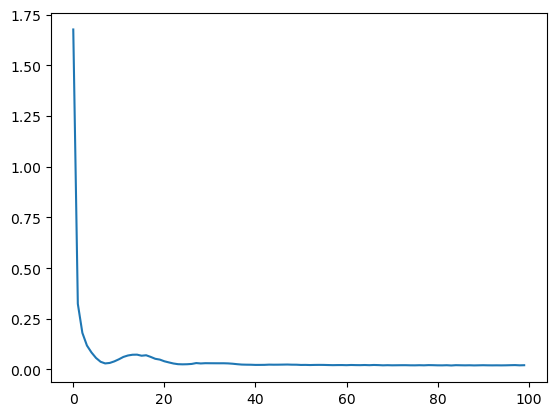

In [407]:
plt.plot(mse_list)

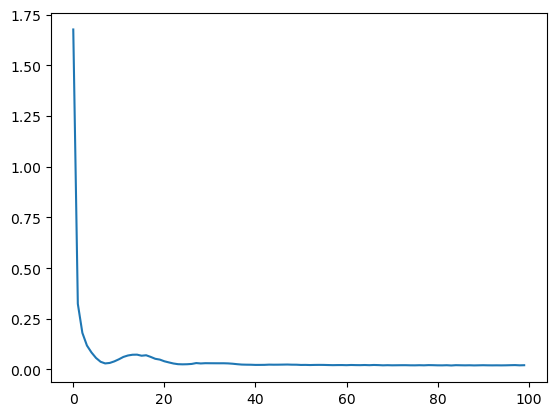

In [408]:
plt.plot(mse_list)

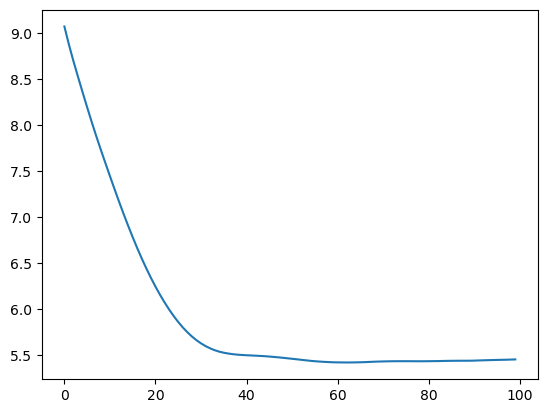

In [409]:
plt.plot(kl_losses)

In [410]:
shuffled_indicies.shape

torch.Size([30050])

In [411]:
op.shape

(1000, 601)

In [421]:
x_test=torch.from_numpy(io[90,:,:]).float()
y_test=op[50:,:]
y_test_mean=np.mean(y_test,axis=0)
y_test_sd=np.std(y_test,axis=0)

In [422]:
num_realizations = 1000
all_fits = []
for _ in range(num_realizations):
    fit = model_car(x_test)
    all_fits.append(fit.data.numpy())
    
all_fits = np.array(all_fits)


In [423]:
mean_fit = np.mean(all_fits, axis=0)
std_fit = np.std(all_fits, axis=0)

In [424]:
l2_norm=np.linalg.norm(mean_fit-y_test_mean.reshape(-1,1))
normalized_l2_norm=l2_norm/(np.linalg.norm(y_test_mean.reshape(-1,1)))
l2_norm_std=np.linalg.norm(std_fit-y_test_sd.reshape(-1,1))
normalized_l2_sd=l2_norm_std/(np.linalg.norm(y_test_sd.reshape(-1,1)))

In [425]:
meanplus=mean_fit+ 2*std_fit
meanminus=mean_fit-2*std_fit

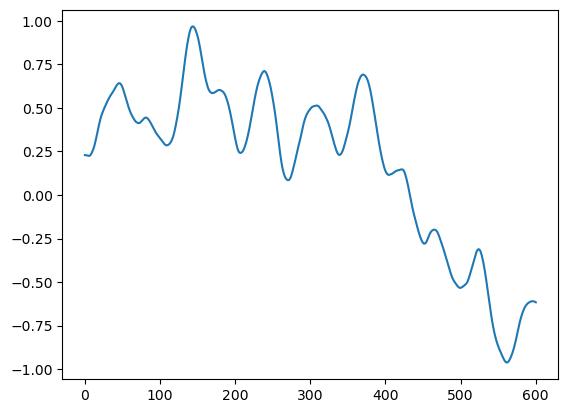

In [426]:
plt.plot(op[90,:])

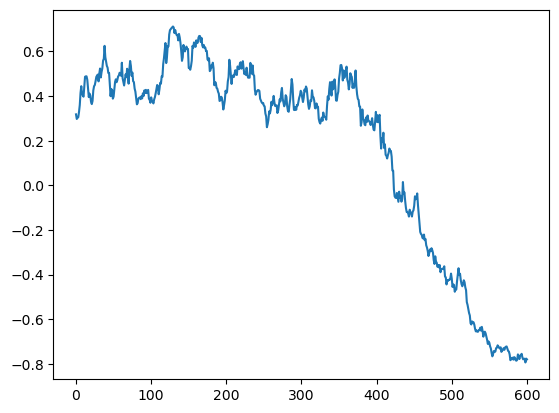

In [427]:
plt.plot(mean_fit)

In [428]:

model_variables = {
        "prior_mu": 0.0,
        "prior_sigma": 1,
        "posterior_mu_init": 0.0,
        "posterior_rho_init": 0.0,
        "type": "Reparameterization",  # Flipout or Reparameterization
        "moped_enable": True,  # True to initialize mu/sigma from the pretrained dnn weights
        "moped_delta": 0.5,
    'learning_rate': ler,
    "kl_weight": kl_weight,
    'iterations':iterations,
}


 MEAN VALIDATION ERROR-----0.27787672049009937
 SD VALIDATION ERROR------0.6610320560970392


{'prior_mu': 0.0, 'prior_sigma': 1, 'posterior_mu_init': 0.0, 'posterior_rho_init': 0.0, 'type': 'Reparameterization', 'moped_enable': True, 'moped_delta': 0.5, 'learning_rate': 0.1, 'kl_weight': 1.5, 'iterations': 50}


Sequential(
  (0): LinearReparameterization()
  (1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Tanh()
  (3): LinearReparameterization()
  (4): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)




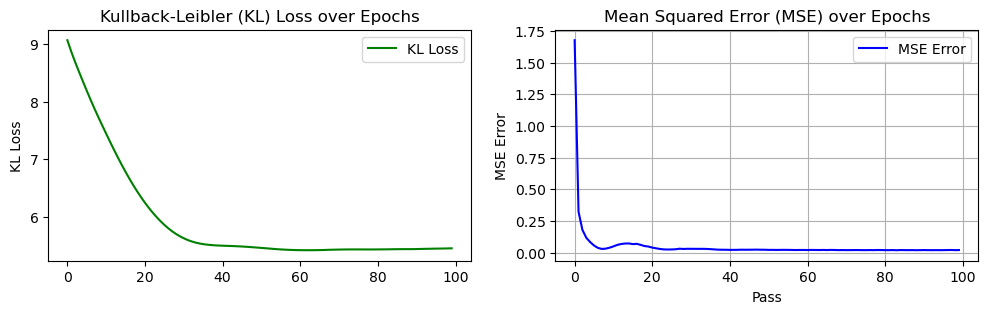

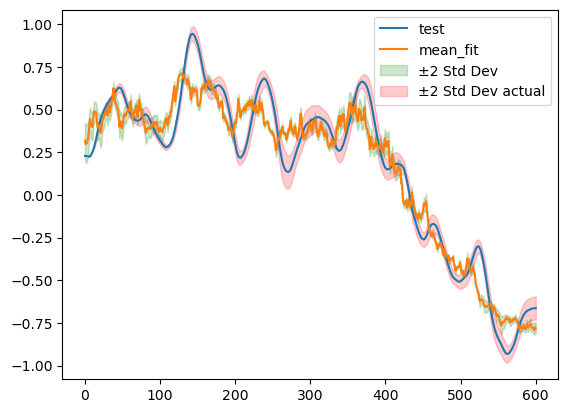

In [443]:

print(" MEAN VALIDATION ERROR-----{}".format(normalized_l2_norm))
print(" SD VALIDATION ERROR------{}".format(normalized_l2_sd))

print('\n')



fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))
ax2.plot(mse_list, label='MSE Error', color='blue')
ax2.set_xlabel('Pass')
ax2.set_ylabel('MSE Error')
ax2.set_title('Mean Squared Error (MSE) over Epochs')
ax2.legend()
ax2.grid(True)

# Create another subplot for KL Loss
ax1.plot(kl_losses, label='KL Loss', color='green')
ax1.set_ylabel('KL Loss')
ax1.set_title('Kullback-Leibler (KL) Loss over Epochs')
ax1.legend(loc='upper right')

print(model_variables)
print('\n')
print(model_car)
print('\n')
plt.figure()

plt.plot(np.arange(0,601),y_test_mean,label='test')
plt.plot(mean_fit,label='mean_fit')
plt.legend()
plt.fill_between(np.arange(0,601), (mean_fit - 2 * std_fit).squeeze(), (mean_fit + 2 * std_fit).squeeze(), color='green', alpha=0.2, label='±2 Std Dev')
plt.fill_between(np.arange(0,601), (y_test_mean - 2 * y_test_sd).squeeze(), (y_test_mean + 2 * y_test_sd).squeeze(), color='red', alpha=0.2, label='±2 Std Dev actual')
plt.legend()

## The displacement plot

In [177]:
y_outside=op[50:,:]

In [179]:
y_outside_mean=np.mean(y_outside,axis=0)

In [182]:
y_outside_mean.shape

(601,)

In [183]:
y_outside_sd=np.std(y_outside,axis=0)

In [184]:
y_outside_sd.shape

(601,)

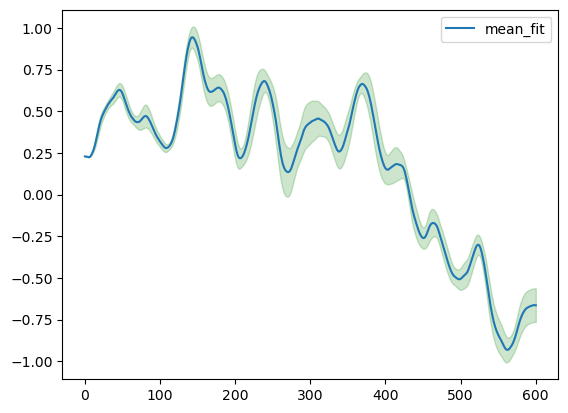

In [187]:
#plt.plot(np.arange(0,601),y_test.data.numpy(),label='test')
plt.plot(y_outside_mean,label='mean_fit')
plt.legend()
plt.fill_between(np.arange(0,601), (y_outside_mean - 3 * y_outside_sd), (y_outside_mean + 3 * y_outside_sd), color='green', alpha=0.2, label='±2 Std Dev')

In [45]:
cost


tensor([1.3171], grad_fn=<AddBackward0>)

In [49]:
x_torch.shape

torch.Size([1000, 601, 2])

In [50]:
y_torch.shape

torch.Size([1000, 1, 601])

### Normal NNs

In [30]:
num_layers = len(list(model_car.children()))
model_info = {
    'num_layers': num_layers,
    'units_per_layer': [1,10,1],
    'mse_loss': mse_loss,
    'mse_list': mse_list,
    'rel_mse_list': rel_mse_list,
    'rel_mse_loss': rel_mse,
    'min_loss': min(mse_list),
    'min_rel_mse': min(rel_mse_list),
    'kl_divergence': kl,
    'kl_weight': kl_weight,
    'learning_rate': lr
}

In [31]:
direct

'C:\\Users\\ad3389\\OneDrive - Northern Arizona University\\Desktop\\BNN_Multi_fidelity_TL\\logs'

In [32]:
def log_information_with_loss_list(log_file, model_info,direct):
    total_path=os.path.join(direct,log_file)
    
    with open(total_path, 'a') as file:
        
        file.write('\n' * 5)
                
        file.write(f"Number of Layers: {model_info['num_layers']}\n")
        file.write(f"Units in Each Layer: {model_info['units_per_layer']}\n")
        file.write(f"mse_loss: {model_info['mse_loss']}\n")
        file.write(f"rel_mse_loss: {model_info['rel_mse_loss']}\n")
        file.write(f"Minimum Loss: {model_info['min_loss']}\n")
        file.write(f"min_rel_mse: {model_info['min_rel_mse']}\n")
        file.write(f"KL Divergence: {model_info['kl_divergence']}\n")
        file.write(f"KL Weight: {model_info['kl_weight']}\n")
        file.write(f"Learning Rate: {model_info['learning_rate']}\n\n")
        file.write(f"mse_list: {model_info['mse_list']}\n")
        file.write(f"rel_mse_list: {model_info['rel_mse_list']}\n")

        print("Log file created successfully.")



In [33]:
def log_information(log_file, model_info,direct):
    
    total_path=os.path.join(direct,log_file)
    
    with open(total_path, 'a') as file:
                
        file.write(f"Number of Layers: {model_info['num_layers']}\n")
        file.write(f"Units in Each Layer: {model_info['units_per_layer']}\n")
        file.write(f"mse_loss: {model_info['mse_loss']}\n")
        file.write(f"rel_mse_loss: {model_info['rel_mse_loss']}\n")
        file.write(f"Minimum Loss: {model_info['min_loss']}\n")
        file.write(f"min_rel_mse: {model_info['min_rel_mse']}\n")
        file.write(f"KL Divergence: {model_info['kl_divergence']}\n")
        file.write(f"KL Weight: {model_info['kl_weight']}\n")
        file.write(f"Learning Rate: {model_info['learning_rate']}\n\n")


        print("Log file created successfully.")



In [34]:
log_information_with_loss_list('log_{}_loss_list.txt'.format(today_date), model_info,direct)

Log file created successfully.


In [35]:
log_information('log_{}.txt'.format(today_date), model_info,direct)

Log file created successfully.


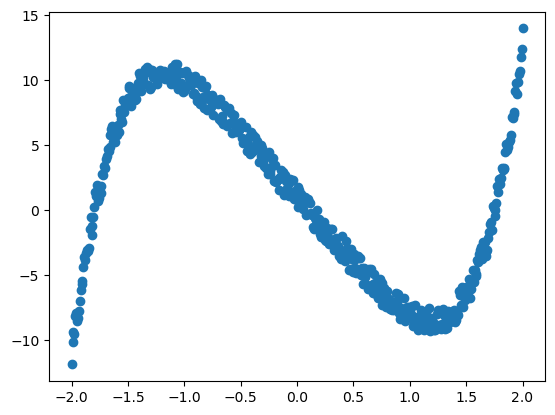

In [86]:
x = torch.linspace(-2, 2, 500)
y = x.pow(5) -10* x.pow(1) + 2*torch.rand(x.size())
x = torch.unsqueeze(x, dim=1)
y = torch.unsqueeze(y, dim=1)

plt.scatter(x.data.numpy(), y.data.numpy())
plt.show()

In [90]:
x.shape

torch.Size([500, 1])

In [107]:
y.shape

torch.Size([500, 1])

In [535]:
mse_list

[array(0.24159057, dtype=float32),
 array(0.08028367, dtype=float32),
 array(0.06811801, dtype=float32),
 array(0.5710897, dtype=float32),
 array(0.23043574, dtype=float32),
 array(0.2785191, dtype=float32),
 array(0.32235688, dtype=float32),
 array(0.32419676, dtype=float32),
 array(0.32601178, dtype=float32),
 array(1.1493932, dtype=float32),
 array(0.23058666, dtype=float32),
 array(0.46971875, dtype=float32),
 array(0.23750074, dtype=float32),
 array(0.61541575, dtype=float32),
 array(0.5440377, dtype=float32),
 array(0.09447826, dtype=float32),
 array(0.39997557, dtype=float32),
 array(0.13477156, dtype=float32),
 array(0.14459395, dtype=float32),
 array(0.32763997, dtype=float32),
 array(0.28388527, dtype=float32),
 array(0.3671469, dtype=float32),
 array(0.41327217, dtype=float32),
 array(0.07247515, dtype=float32),
 array(0.7752722, dtype=float32),
 array(0.6617238, dtype=float32),
 array(0.17378263, dtype=float32),
 array(0.45089757, dtype=float32),
 array(0.656727, dtype=floa

In [67]:
torch.cuda.is_available()

False

In [2]:
import sys

'C:\\Users\\ad3389\\AppData\\Local\\anaconda3\\envs\\bifidelity_2\\python.exe'

In [4]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118
